#### NCCU, Fall 2020
#### **PyTorch and Machine Learning**
##### 107363015 郭育丞 (Morton Kuo)

---
#### **ML18: NLP - Surname Classification**
##### https://medium.com/analytics-vidhya/ml18-6e9b1b66c30e
##### @author: Morton Kuo (2021 / 01 / 05)


---
### PART III: Surname Classification by CNN

*   The outcome here is ***the best*** CNN classifier I found.
*   The code mainly comes from the book ***Rao, D. & McMahan, B. (2019). Natural Language Processing with PyTroch. California, CA: O’Reilly Media***. Based on that, I tune the model and visualize the outcomes.

---
### Outline
*   (1) Data Source & Setting Hardware
*   (2) Import
*   (3) Vectorizing Data
*   (4) Model: CNN
*   (5) Settings
*   (6) Training Routine
*   (7) Model Evaluation
*   (8) Inference




---
### Reference

1. Géron, A. (2019). Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd ed.). California, CA: O’Reilly Media.
2. Rao, D. & McMahan, B. (2019). Natural Language Processing with PyTroch. California, CA: O’Reilly Media. 
3. Sarkar, D. (2019). Text Analytics with Python (2nd ed.). Karnataka, India: Apress.
4. Ganegedara, T. (2018). Natural Language Processing with TensorFlow. Birmingham, UK: Packt Publishing.
5. Subramanian, V. (2018). Deep Learning with PyTorch. Birmingham, UK: Packt Publishing.
6. Patterson, J. & Gibson, A. (2017). Deep Learning: A Practitioner's Approach. California, CA: O’Reilly Media.
7. 斎藤康毅 (2016). ゼロから作るDeep Learning ―Pythonで学ぶディープラーニングの理論と実. Japan, JP: O’Reilly Japan.
8. Kuo, M. (2021). ML16: Hands-on Text Preprocessing. Retrieved from
https://medium.com/analytics-vidhya/ml16-ef6105b5bb34#6ef4



---
### (1) Data Source & Setting Hardware
To proceed the code, \
1. Kindly donwnload the "surnames_with_splits.csv" dataset from the link below and upload it to Colab.\
https://bit.ly/3n0UHPn \
2. Then, switch the Colab hardware to GPU: "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> Choose "GPU".

---
### (2) Import

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

---
### (3) Vectorizing Data

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1
        
        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(), 
                'max_surname_length': self._max_surname_length}

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            name_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

---
### (4) Model: CNN

In [ ]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels, 
                      out_channels=num_channels, kernel_size=3),
            nn.BatchNorm1d(num_channels),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.BatchNorm1d(num_channels),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.BatchNorm1d(num_channels),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3),
            nn.BatchNorm1d(num_channels),
            nn.ELU()
        )
        '''
        self.fc1 = nn.Sequential(
            nn.Linear(num_channels, 100),
            nn.LeakyReLU())
        '''
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        features = self.convnet(x_surname).squeeze(dim=2)
        # features_2 = self.fc1(features_1)
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector


---
### (5) Settings

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

In [ ]:
def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [ ]:
def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
args = Namespace(
    # Data and Path information
    surname_csv="surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "model_storage",
    # Model hyper parameters
    # hidden_dim= 100, # baseline: 100
    num_channels= 280,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size= 8, # baseline: 128
    num_epochs= 30,
    weight_decay = 5e-5,
    early_stopping_criteria=5,
    # dropout_p=0.3,
    # Runtime options
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: True


---
### (6) Training Routine

In [ ]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab), 
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

classifer = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay= args.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

In [ ]:
import time as t
t1 = t.perf_counter()

try:
    for epoch_index in range(args.num_epochs):

        # Record the tarining stage
        if (epoch_index+1) % 10 == 0:
          print("Epoch [{}/{}]".format(epoch_index+1, args.num_epochs))

        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0

        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

except KeyboardInterrupt:
    print("Exiting loop")


print('-----')
t2 = t.perf_counter()
print("Running time = {:.2f}".format(t2-t1))

Epoch [10/30]
Epoch [20/30]
Epoch [30/30]
-----
Running time = 203.15


---
### (7) Model Evaluation

In [ ]:
print(len(train_state['train_acc']))
print(len(train_state['val_acc']))

30
30


In [ ]:
'''
#### Plotting -- 1

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (30, 5.5))
train_accu, val_accu = train_state['train_acc'], train_state['val_acc']

# record records the (training accuracy, test accuracy) in each step
plt.plot(list(range(1,101)), train_accu, label= "Training data") 
plt.plot(list(range(1,101)), val_accu, label= "Test data")

plt.xticks(range(0, 101, 1))
plt.yticks(range(0, 96, 5))
plt.axis([0,101, 0, 96]) # Adjust the scope

plt.xlabel('Steps', fontsize = 'xx-large') # Change font size
plt.ylabel('Error rate (%)')
plt.ylabel('Error rate (%)', fontsize = 'xx-large') # Change font size
plt.title('CNN: Error rate (%)', fontname='DejaVu Sans', fontsize = 'xx-large') # Change font size

plt.grid() # Simply add grid by default
plt.legend(fontsize = 'xx-large',  loc= 'lower center')
plt.show()
'''

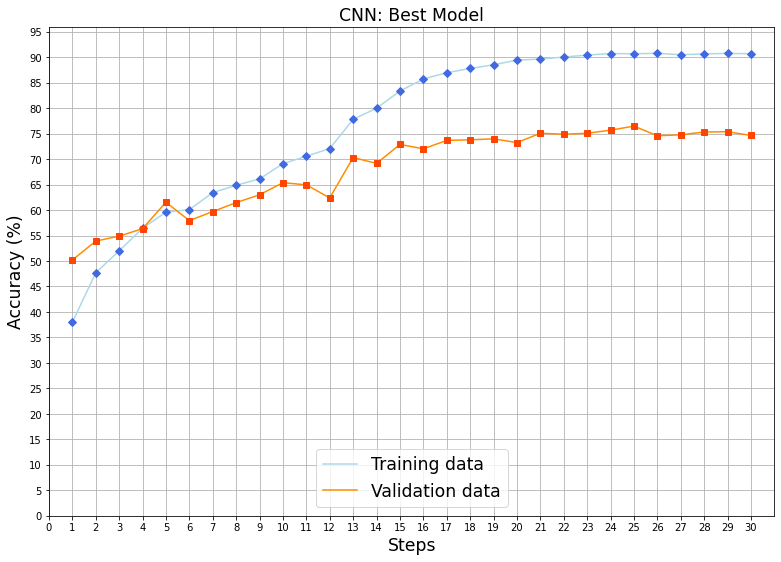

In [ ]:
#### Plotting -- 2

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (13, 9))
train_accu, val_accu = train_state['train_acc'][:30], train_state['val_acc'][:30]

# record records the (training accuracy, test accuracy) in each step
plt.plot(list(range(1,31)), train_accu, color='lightblue', label= "Training data") 
plt.plot(list(range(1,31)) ,  train_accu, 'D', color='royalblue')  
plt.plot(list(range(1,31)), val_accu, color='darkorange', label= "Validation data")
plt.plot(list(range(1,31)) ,  val_accu, 's', color='orangered')  

plt.xticks(range(0, 31, 1))
plt.yticks(range(0, 96, 5))
plt.axis([0, 31, 0, 96]) # Adjust the scope

plt.xlabel('Steps', fontsize = 'xx-large') # Change font size
plt.ylabel('Accuracy (%)', fontsize = 'xx-large') # Change font size
plt.title('CNN: Best Model', fontname='DejaVu Sans', fontsize = 'xx-large') # Change font size

plt.grid() # Simply add grid by default
plt.legend(fontsize = 'xx-large',  loc= 'lower center')
plt.show()

In [ ]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [ ]:
print("Final Training   Accuracy: {:7.4f}".format(train_state['train_acc'][24]))
print("Final Validation Accuracy: {:7.4f}".format(train_state['val_acc'][24]))
print("Final Test       Accuracy: {:7.4f}".format(train_state['test_acc']))

Final Training   Accuracy: 90.6641
Final Validation Accuracy: 76.4634
Final Test       Accuracy: 71.1957


In [ ]:
print("Test Loss: {}".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test Loss: 1.8299996256828308
Test Accuracy: 55.79427083333333


---
### (8) Inference

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [ ]:
new_surname = input("Enter a surname to classify: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

In [ ]:
def predict_topk_nationality(surname, classifier, vectorizer, k=5):
    """Predict the top K nationalities from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        k (int): the number of top nationalities to return
    Returns:
        list of dictionaries, each dictionary is a nationality and a probability
    """
    
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    prediction_vector = classifier(vectorized_surname, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values[0].detach().numpy()
    indices = indices[0].detach().numpy()
    
    results = []
    for kth_index in range(k):
        nationality = vectorizer.nationality_vocab.lookup_index(indices[kth_index])
        probability_value = probability_values[kth_index]
        results.append({'nationality': nationality, 
                        'probability': probability_value})
    return results

new_surname = input("Enter a surname to classify: ")

k = int(input("How many of the top predictions to see? "))
if k > len(vectorizer.nationality_vocab):
    print("Sorry! That's more than the # of nationalities we have.. defaulting you to max size :)")
    k = len(vectorizer.nationality_vocab)
    
predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))